In [1]:
import msprime, pyslim
import tskit
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

We want to verify that the 2-d distribution of individual x-coordinates over time, $u(x, t)$, satisfies the porous medium equation:

$$\frac{d}{dt} u(x,t) = \frac{\sigma^2}{2}\frac{d^2}{dx^2}(u(x,t)^2) + u(x, t)(1-u(x,t))$$

Strategy:

1. Use Gaussian kernel density estimation to estimate $u(x, t)$ from the simulated locations
2. Calculate discrete approximations of $\frac{d}{dt} \widehat{u(x,t)}$ and  $\frac{d^2}{dx^2} \left(\widehat{u(x,t)}^2 \right)$

## Simulation

In [2]:
#! slim -d 'OUTPATH="pme_test.trees"' -d WIDTH=20 -d HEIGHT=2 -d NUMGENS=10 -d DISPERSAL_SIGMA=0.2 -d SIGMA=0.2 pme.slim  >/dev/null
ts = pyslim.load("pme_1d.trees")

In [3]:
sigma = ts.metadata['SLiM']['user_metadata']['DISPERSAL_SIGMA'][0]
dt = ts.metadata['SLiM']['user_metadata']['DT'][0]
K = ts.metadata['SLiM']['user_metadata']['K'][0]

In [4]:
max_x = round(max(ts.individual_locations[:,0]))
max_y = max(ts.individual_locations[:,1])
min_y = min(ts.individual_locations[:,1])
max_t = max(ts.individual_times)

print(max_x, max_y, min_y, max_t)

20 100000000.0 -7.953031540099203e+306 499.0


## Use Gaussian KDE to estimate $u(x, t)$

In [5]:
t = 0
inds = ts.individuals_alive_at(t)
locations = ts.individual_locations[inds]
dataset = locations[:,0]
print(np.shape(dataset))
uhat = stats.gaussian_kde(dataset)

(6828,)


In [6]:
x = np.arange(0, max_x)

popsize = pyslim.population_size(ts, x, [min_y, max_y], [0, 1])
help(pyslim.population_size)

Help on function population_size in module pyslim.spatial:

population_size(ts, x_bins, y_bins, time_bins, stage='late', remembered_stage=None)
    Calculates the population size in each of the spatial bins defined by grid lines
    at ``x_bins`` and ``y_bins``, averaged over each of the time intervals separated by
    ``time_bins``. To obtain actual (census) sizes, the tree sequence must contain
    all individuals alive, e.g., from a SLiM simulation with all individuals
    permanently remembered.
    
    With ``nx``, ``ny`` and ``nt`` the number of bins in the ``x``, ``y`` and time directions
    (so, ``nx`` is one less than the length of ``x_bins``),
    returns a 3-d array with dimensions ``(nx, ny, nt)``.
    The ``(i,j,k)``th element of the array is the average number of
    individuals with ``x`` coordinate in the half-open interval ``[x_bins[i], x_bins[i + 1])``
    and ``y`` coordinate in the half-open interval ``[y_bins[i], y_bins[i + 1])``,
    averaged across all times in

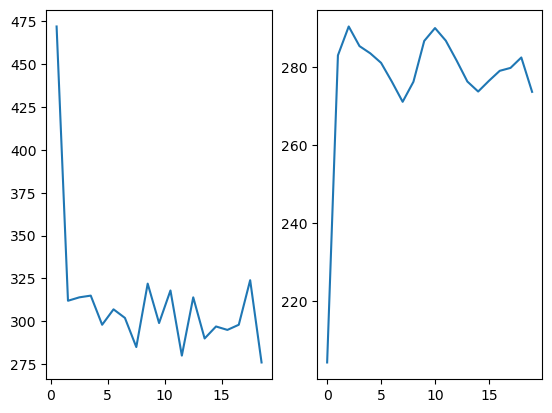

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x[:-1] + np.diff(x/2), popsize.flatten().flatten()/np.diff(x))

pdf = uhat.evaluate(x)*np.sum(popsize)
ax2.plot(x, pdf)
plt.show()


## Discrete derivatives

$\frac{d}{dt} \widehat{u(x,t)} \approx \frac{\widehat{u(x, t + h)} - \widehat{u(x, t)}}{h}$

$\frac{d}{dx} \widehat{u(x,t)^2} \approx \frac{\widehat{u(x + h, t)^2} - \widehat{u(x, t)^2}}{h}$

$\frac{d^2}{dx^2} \widehat{u(x,t)^2} \approx \frac{\widehat{\frac{d}{dx}u(x + h, t)^2} - \widehat{\frac{d}{dx}u(x, t)^2}}{h} = \frac{\frac{\widehat{u(x + 2h, t)^2} - \widehat{u(x + h, t)^2}}{h} - \frac{\widehat{u(x + h, t)^2} - \widehat{u(x, t)^2}}{h}}{h} = \frac{\widehat{u(x + 2h, t)^2} - 2\widehat{u(x + h, t)^2} + \widehat{u(x, t)^2}}{h^2}$

In [8]:
h1 = 1e-3
h2 = 1e-6

x_bins = np.arange(0, max_x, 2)
time_bins = np.arange(1, max_t + 1)

x_vals = np.empty(len(time_bins)*len(x_bins))
t_vals = np.empty(len(time_bins)*len(x_bins))

ddx1_vals = np.empty(len(time_bins)*len(x_bins))
ddx2_vals = np.empty(len(time_bins)*len(x_bins))
d2dx21_vals = np.empty(len(time_bins)*len(x_bins))
d2dx22_vals = np.empty(len(time_bins)*len(x_bins))
lhs = np.empty(len(time_bins)*len(x_bins))
rhs = np.empty(len(time_bins)*len(x_bins))

def get_uhat_t(t, ts):
    inds = ts.individuals_alive_at(t)
    locations = ts.individual_locations[inds]
    dataset = locations[:,0]
    return stats.gaussian_kde(dataset)

i = 0
for t in time_bins:
    uhat_t = get_uhat_t(t, ts)
    uhat_tm1 = get_uhat_t(t-1, ts)
    for x in x_bins:
        ddt = uhat_t.evaluate(x) - uhat_tm1.evaluate(x)
        
        x_vals[i] = x
        t_vals[i] = t

        #ddx1 = (uhat.evaluate(x + h1) - uhat.evaluate(x))/h1
        #ddx2 = (uhat.evaluate(x + h2) - uhat.evaluate(x))/h2
        
        #ddx1 = evaluate_uhat(t, x, dx, ts) - evaluate_uhat(t - 1, x, dx, ts)
        
        #ddx1_vals[i] = ddx1
        #ddx2_vals[i] = ddx2        
        #print(ddx1, ddx2)

        d2dx21 = (uhat.evaluate(x + 2*h1)**2 - 2*uhat.evaluate(x + h1)**2 + uhat.evaluate(x)**2)/h1**2
        d2dx22 = (uhat.evaluate(x + 2*h2)**2 - 2*uhat.evaluate(x + h2)**2 + uhat.evaluate(x)**2)/h2**2

        d2dx21_vals[i] = d2dx21
        d2dx22_vals[i] = d2dx22
        #print(d2dx21, d2dx22)

        uxt = uhat.evaluate(x)

        lhs[i] = ddt
        rhs[i] = ((sigma**2/2)*d2dx21 + uxt*(1 - uxt))
        i += 1

#print(lhs)
#print(rhs)

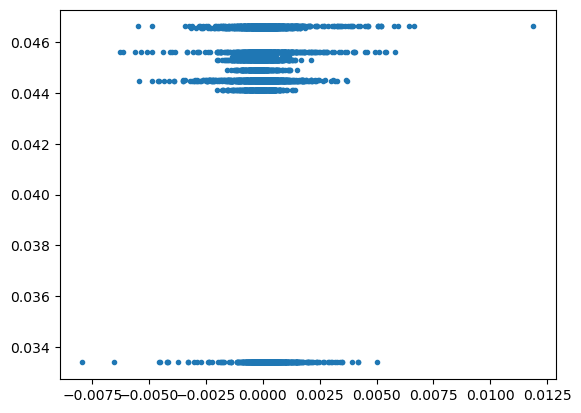

In [9]:
fig, ax = plt.subplots()
ax.plot(lhs, rhs, '.')
plt.show()

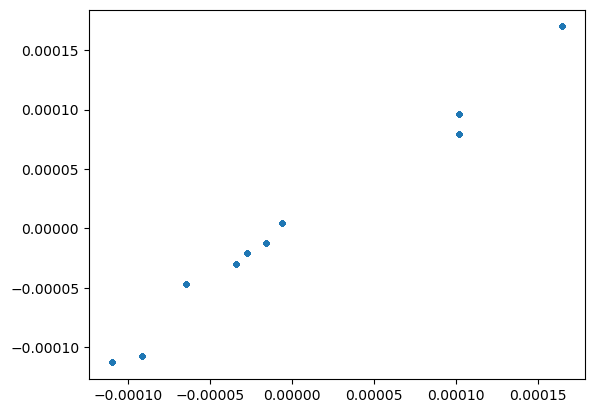

In [10]:
fig, ax = plt.subplots()
ax.plot(d2dx21_vals, d2dx22_vals, '.')
ax.plot([0, 0], [8e-12, 8e-12])
plt.show()



## Instead of Gaussian KDE

$h$ - size of $x$ bins

$\widehat{u_t(x)} = \frac{\text{population size between } x \text{ and } x + h \text{ at time } t}{h (\text{total population size at time } t)}$

$\frac{d}{dt} \widehat{u_t(x)} \approx \widehat{u(x, t)} - \widehat{u(x, t - 1)}$

$\frac{d^2}{dx^2} \widehat{u(x,t)^2} \approx \frac{\widehat{\frac{d}{dx}u(x + h, t)^2} - \widehat{\frac{d}{dx}u(x, t)^2}}{h} = \frac{\frac{\widehat{u(x + 2h, t)^2} - \widehat{u(x + h, t)^2}}{h} - \frac{\widehat{u(x + h, t)^2} - \widehat{u(x, t)^2}}{h}}{h} = \frac{\widehat{u(x + 2h, t)^2} - 2\widehat{u(x + h, t)^2} + \widehat{u(x, t)^2}}{h^2}$

In [11]:
h = 0.8
y_bins = [min_y, max_y]
x_bins = np.arange(0, round(max_x)+h, h)
t_bins = np.arange(0, max_t + 1)
popsize = pyslim.population_size(ts, x_bins, y_bins, t_bins)

In [12]:
print(len(x_bins))
print(max_t)

26
499.0


In [13]:
uhat = popsize[:,0, :]/(K*h)

print(np.shape(uhat))
print(len(x_bins))
print(len(t_bins))

(25, 499)
26
500


`uhat` is a $n_x$ = `len(x_bins) - 1` by $n_t$ = `len(t_bins) - 1` grid.

$d/dt$ `uhat` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `uhat[i, j -1] - uhat[i, j]`

So I can calculate $d/dt$ for $i = 0, 1, ..., n_x -1$ and $j = 1, 2, ..., n_t - 1$

$d^2/dx^2$ `uhat` between `x_bins[i]` and `x_bins[i + 1]` and  `t_bins[j]` and `t_bins[j + 1]` $\approx$ `(uhat[i + 1, j]**2 - 2*uhat[i, j] + uhat[i - 1, j])/h**2`

So I can calculate $d^2/dx^2$ for $i = 1, ..., n_x - 2$ and $j = 0, 1, 2, ..., n_t - 1$

And both for $i = 1, ..., n_x - 2$ and $j = 1, 2, ..., n_t - 1$



In [14]:
nx = np.shape(uhat)[0]
nt = np.shape(uhat)[1]

i_vals = np.arange(1, nx - 1)
j_vals = np.arange(1, nt)

x_vals = np.empty([len(i_vals),len(j_vals)])
t_vals = np.empty([len(i_vals),len(j_vals)])

lhs = np.empty([len(i_vals),len(j_vals)])
rhs = np.empty([len(i_vals),len(j_vals)])

for i_index, i in enumerate(i_vals):
    for j_index, j in enumerate(j_vals):
        x = x_bins[i]
        t = t_bins[j]
        
        uhatt = uhat[i, j]
        uhattm1  = uhat[i, j-1]
        
        ddt = (uhattm1 - uhatt)
    
        d2dx2 = (uhat[i + 1, j]**2 - 2*uhat[i, j]**2 + uhat[i - 1, j]**2)/h**2
    
        x_vals[i_index, j_index] = x
        t_vals[i_index, j_index] = t   
    
        lhs[i_index, j_index] = ddt
        #rhs[index] = dt*((sigma**2/2)*d2dx2 + uhatt*(1 - uhatt))
        rhs[i_index, j_index] = dt*(sigma**2/2)*d2dx2 + uhatt*(np.exp(-dt*(2*uhatt - 1)) - np.exp(-dt*uhatt))

In [15]:
np.shape(lhs)

(23, 498)

In [16]:
print(lhs[:,1])

[ 0.015625 -0.0125    0.028125  0.003125 -0.01875   0.01875   0.00625
  0.        0.025     0.009375  0.021875 -0.00625   0.00625   0.021875
  0.025     0.00625   0.015625 -0.003125  0.040625 -0.009375  0.03125
 -0.0375   -0.021875]


In [17]:
sum_lhs = np.sum(lhs, axis = 0)
sum_rhs = np.sum(rhs, axis = 0)

In [18]:
print(popsize)
gamma = 1-np.exp(-dt*150/K)
mu = 1-np.exp(-dt*(2*150/K - 1))
print(gamma*150, mu*150)


[[[416. 422. 427. ... 305. 298. 293.]]

 [[243. 243. 238. ... 298. 299. 301.]]

 [[247. 247. 251. ... 281. 282. 284.]]

 ...

 [[225. 238. 250. ...   0.   0.   0.]]

 [[235. 227. 234. ...   0.   0.   0.]]

 [[405. 408. 407. ...   0.   0.   0.]]]
5.520837341876728 -3.7972680786643287


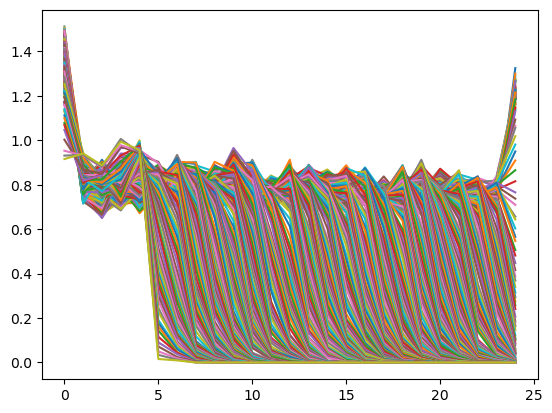

In [19]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(uhat)
plt.show()

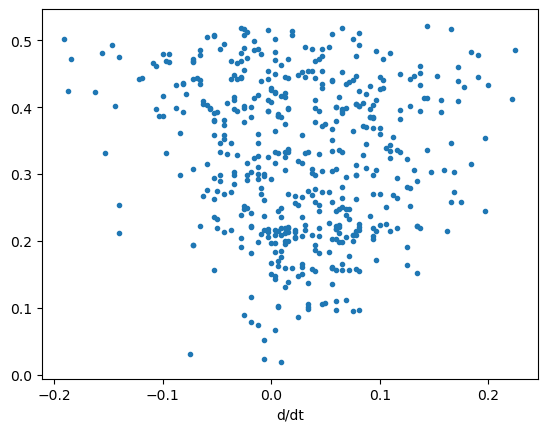

In [20]:
fig, ax = plt.subplots()
ax.plot(sum_lhs, sum_rhs, '.')
ax.set_xlabel("d/dt")
plt.show()

In [21]:
np.shape(uhat)

(25, 499)